In [2]:
cd ~/Desktop/DeepLearningPilot/

/Users/jz-rolling/Desktop/DeepLearningPilot


In [3]:
import tensorflow as tf,matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize,rescale
from skimage import measure, segmentation,morphology,filters,feature,exposure
import tifffile
import momia2 as mo
from momia2.classify.classifier_helper import *
import timeit
import pickle as pk
from tensorflow import keras
from unet import *
import glob, os
import read_roi
import seaborn as sns
from matplotlib.gridspec import GridSpec as gs

### Define function to remove problematic colonies

In [4]:
def filter_colonies(self):
    drop_list = []
    for l, v in self.is_touching_edge.items():
        if 1 in v:
            if np.where(v==1)[0][0] == np.where(self.colony_growths[l]>0)[0][0]:
                drop_list.append(l)
        if not filter_by_growth(self.colony_growths[l]):
            drop_list.append(l)
    for l in np.unique(drop_list):
        self.labels[self.labels==l]=0
        g = self.colony_growths.pop(l)
        t = self.is_touching_edge.pop(l)

### Extract colony expansion statistics

In [731]:
init_day = 20221123
init_hour = 9
init_min = 20

growths = []
time_stamps = []
colony_ids = []
plate_ids = []
columns = []
rows = []

for f in sorted(glob.glob('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/*.pk')):
    plate = int(f.split('/')[-1].split('.')[0][-2:])
    d = pk.load(open(f,'rb'))
    
    # extact time
    times = []
    for x in list(d.keys())[:-1]:
        day, time, _plate = x.split('-')
        day,hour,minute = int(day),int(time[:2]),int(time[2:])
        d_hour = 24*(day-init_day) + (hour-init_hour) + (minute-init_min)/60
        times.append(d_hour)
    
    for k,v in d['Prediction'].items():
        data = correct_tl_ND(v,ref_channel=3)[0]
        c = mo.colony.Colony(images = data[:,:,:,0],
                      masks = data[:,:,:,3]>0.95,
                      edges = data[:,:,:,2],
                      dates = times)
        c.fill_holes(area_threshold=50)
        c.render_highcontrast_images(p1=70)
        c.link_colonies()
        c.measure_growth()
        #c.filter_colonies()
        c.label_colonies()
        c.inspect_colonies()
        for cid, g in c.colony_growths.items():
            time_stamps += times
            growths += list(g)
            colony_ids += ['{}_{}_{}'.format(plate,k,cid)]*len(g)
            plate_ids += [plate]*len(g)
            columns += [k[-1]]*len(g)
            rows += [k[0]]*len(g)
df = pd.DataFrame({'colony_id':colony_ids,'time':time_stamps,'area':growths,'plate':plate_ids,'row':rows,'col':columns})
df['group'] = ['group_1' if x in ['A','B','C'] else 'group_2' for x in df['row']]
df['Rapa'] = ['+Rapa' if x%2 == 0 else '-Rapa' for x in df['plate']]
df.to_csv('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/colony_stat.csv')

In [ ]:
#df = pd.read_csv('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/colony_stat.csv')
df = pd.read_csv('/assets/colony_stat.csv')

In [6]:
filtered = []
for c in df['colony_id'].unique():
    subset = df[df['colony_id']==c].copy()
    v = subset['area'].values
    cond1 = v[:2].max()>50
    cond2 = (np.sum(v>0)>=3) & ((v.max()-v[v>0].mean())<200)
    cond3 = np.sum((v[1:]-v[:-1])<-10)>0
    if cond1+cond2+cond3 == 0:
        filtered.append(subset)
filtered = pd.concat(filtered)

### Plot demo grid images

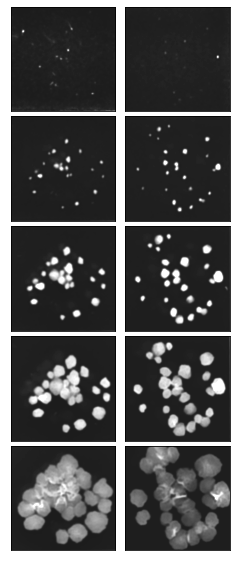

In [648]:
plate2 = 'plate02'
plate1 = 'plate{}'.format(str(int(plate2[5:])-1).zfill(2))

f1 = '/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/{}.pred_results.pk'.format(plate1)
f2 = '/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/{}.pred_results.pk'.format(plate2)

roi1 = read_roi.read_roi_zip('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/{}_rois.zip'.format(plate1))
roi2 = read_roi.read_roi_zip('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/{}_rois.zip'.format(plate2))

d1 = pk.load(open(f1,'rb'))
d2 = pk.load(open(f2,'rb'))

ctrl_k = 'D-4'
exp_k = 'E-4'

ctrl = correct_tl_ND(d1['Prediction'][ctrl_k],ref_channel=3)[0]
exp = correct_tl_ND(d2['Prediction'][exp_k],ref_channel=3)[0]

fig = plt.figure(figsize=(4,10))
grids = gs(5,2,hspace=0.05,wspace=0.05)
for i,t in enumerate([1,3,5,6,7]):
    ax = fig.add_subplot(grids[i,0])
    v = ctrl[t,:,:,0]
    if np.mean(v)<0.2:
        x,y,dx,dy = roi1[ctrl_k]['top'],roi1[ctrl_k]['left'],roi1[ctrl_k]['height'],roi1[ctrl_k]['width']
        recropped = d1[list(d1.keys())[t]][x:x+dx,y:y+dy]
        v=recropped
    v = normalize_image(v,mask=morphology.binary_dilation(ctrl[t,:,:,3]>0.5,morphology.disk(3)),bg=0.01)
    ax.imshow(v,'gist_gray',vmin=-0.1,vmax=0.8)
    ax.set_xticks([])
    ax.set_yticks([])
    
for i,t in enumerate([1,3,5,6,7]):
    ax = fig.add_subplot(grids[i,1])
    v = exp[t,:,:,0]
    if np.mean(v)<0.2:
        x,y,dx,dy = roi2[exp_k]['top'],roi2[exp_k]['left'],roi2[exp_k]['height'],roi2[exp_k]['width']
        recropped = d2[list(d2.keys())[1]][x:x+dx,y:y+dy]
        v=recropped
    v = normalize_image(v,mask=morphology.binary_dilation(ctrl[t,:,:,3]>0.5,morphology.disk(3)),bg=0.01)
    ax.imshow(v,'gist_gray',vmin=-0.1,vmax=0.75)
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/{}.svg'.format(plate2),bbox_inches='tight')

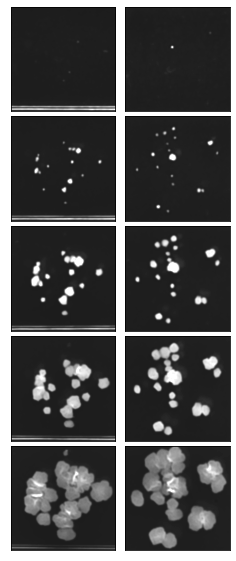

In [57]:
plate2 = 'plate02'
plate1 = 'plate{}'.format(str(int(plate2[5:])-1).zfill(2))

f1 = '/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/{}.pred_results.pk'.format(plate1)
f2 = '/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/{}.pred_results.pk'.format(plate2)

roi1 = read_roi.read_roi_zip('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/{}_rois.zip'.format(plate1))
roi2 = read_roi.read_roi_zip('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/1_gridproj/{}_rois.zip'.format(plate2))

d1 = pk.load(open(f1,'rb'))
d2 = pk.load(open(f2,'rb'))

ctrl_k = 'C-4'
exp_k = 'C-4'

ctrl = correct_tl_ND(d1['Prediction'][ctrl_k],ref_channel=3)[0]
exp = correct_tl_ND(d2['Prediction'][exp_k],ref_channel=3)[0]

fig = plt.figure(figsize=(4,10))
grids = gs(5,2,hspace=0.05,wspace=0.05)
for i,t in enumerate([1,3,5,6,7]):
    ax = fig.add_subplot(grids[i,0])
    v = ctrl[t,:,:,0]
    if np.mean(v)<0.2:
        x,y,dx,dy = roi1[ctrl_k]['top'],roi1[ctrl_k]['left'],roi1[ctrl_k]['height'],roi1[ctrl_k]['width']
        recropped = d1[list(d1.keys())[t]][x:x+dx,y:y+dy]
        v=recropped
    v = normalize_image(v,mask=morphology.binary_dilation(ctrl[t,:,:,3]>0.5,morphology.disk(3)),bg=0.01)
    ax.imshow(v,'gist_gray',vmin=-0.1,vmax=0.8)
    ax.set_xticks([])
    ax.set_yticks([])
    
for i,t in enumerate([1,3,5,6,7]):
    ax = fig.add_subplot(grids[i,1])
    v = exp[t,:,:,0]
    if np.mean(v)<0.2:
        x,y,dx,dy = roi2[exp_k]['top'],roi2[exp_k]['left'],roi2[exp_k]['height'],roi2[exp_k]['width']
        recropped = d2[list(d2.keys())[1]][x:x+dx,y:y+dy]
        v=recropped
    v = normalize_image(v,mask=morphology.binary_dilation(exp[t,:,:,3]>0.5,morphology.disk(3)),bg=0.01)
    ax.imshow(v,'gist_gray',vmin=-0.1,vmax=0.8)
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('/Volumes/JZSSD_temp/202212_Harry_plate_analysis/20221228_output/Ctrl_{}.svg'.format(plate2),bbox_inches='tight')

In [9]:
def xydrift_correction(target_img, shift, max_drift=1000):
    
    if max(np.abs(shift)) <= max_drift:
        return shift_image(target_img, np.array(shift))
    else:
        return target_img
    
def get_xydrift(ref_img, target_img):
    from skimage import registration
    shift, error, _diff = registration.phase_cross_correlation(ref_img, target_img, upsample_factor=10)
    return shift

def shift_image(img, shift):
    from scipy import ndimage as ndi
    """
    correct xy drift between phase contrast image and fluorescent image(s)
    :param img: input image
    :param shift: subpixel xy drift
    :return: drift corrected image
    """
    offset_image = ndi.fourier_shift(np.fft.fftn(img), shift)
    offset_image = np.fft.ifftn(offset_image)
    offset_image = np.round(offset_image.real)
    return offset_image


def correct_tl_ND(pos_data,max_drift=20,ref_channel=3):
    is_weird = [0]
    last_drift = np.array([0,0])
    output_data = []
    for t in range(len(pos_data)):
        if t == 0:
            output_data.append(pos_data[t])
        else:
            shift = get_xydrift(pos_data[t-1,:,:,ref_channel],
                                pos_data[t,:,:,ref_channel])
            if np.abs(shift).max()>max_drift:
                is_weird.append(1)
            else:
                is_weird.append(0)
            last_drift = last_drift + shift
            channel_data = np.zeros(pos_data[t].shape)
            for c in range(pos_data[t].shape[-1]):
                channel_data[:,:,c] = xydrift_correction(pos_data[t,:,:,c],last_drift,max_drift=max_drift)
            output_data.append(channel_data)
    output_data = np.array(output_data)
    return output_data, is_weird

### Plot RAPA- growth dynamics

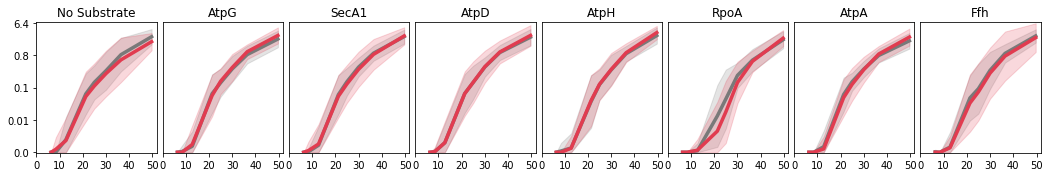

In [7]:
substrate_names = ['No Substrate','AtpG','SecA1','AtpD','AtpH','RpoA','AtpA','Ffh']
ctrl_color=np.array([121,121,121])/255
rapa_color=np.array([225,60,80])/255
pix_n = 2000
w=80
pix_mm = w/pix_n
pix_mm2 = pix_mm**2
fig=plt.figure(figsize=(18,2.4))
grids =gs(1,8,wspace=0.05)
for k,i in enumerate([2,14,10,16,12,4,6,8]):
    substrate = substrate_names[k]
    no_rapa = filtered[(filtered['plate']==i-1)&(filtered['group']=='group_1')].copy()
    no_rapa['Substrate'] = substrate_names[k]
    with_rapa = filtered[(filtered['plate']==i)&(filtered['group']=='group_1')].copy()
    with_rapa['Substrate'] = substrate_names[k]
    ax = fig.add_subplot(grids[:,k])
    stack = []
    for cid in no_rapa['colony_id'].unique():
        subset = no_rapa[no_rapa['colony_id']==cid]
        if subset['area'].values.max()>100:
            stack.append(np.log2(subset['area'].values+1))
            #plt.plot(subset['time'].values,subset['area'].values,color=ctrl_color,lw=1,alpha=0.1)
            times = subset['time'].values
    mean_v, std_v = np.mean(stack,axis=0),np.std(stack,axis=0)
    plt.plot(subset['time'].values[times<52],mean_v[times<52],color=ctrl_color,lw=3.5)
    low_bound = mean_v-std_v
    low_bound[low_bound<0]=0
    high_bound = mean_v+std_v
    high_bound[high_bound>np.log2(4001)]=np.log2(4001)
    plt.fill_between(subset['time'].values[times<52],low_bound[times<52],high_bound[times<52],color=ctrl_color,alpha=0.2)
    stack = []
    for cid in with_rapa['colony_id'].unique():
        subset = with_rapa[with_rapa['colony_id']==cid]
        if subset['area'].values.max()>100:
            stack.append(np.log2(subset['area'].values+1))
            #plt.plot(subset['time'].values,subset['area'].values,color=rapa_color,lw=1,alpha=0.1)
    mean_v, std_v = np.mean(stack,axis=0),np.std(stack,axis=0)
    plt.plot(subset['time'].values[times<52],mean_v[times<52],color=rapa_color,lw=3.5)
    low_bound = mean_v-std_v
    low_bound[low_bound<0]=0
    high_bound = mean_v+std_v
    high_bound[high_bound>np.log2(4001)]=np.log2(4001)
    plt.fill_between(subset['time'].values[times<52],low_bound[times<52],high_bound[times<52],color=rapa_color,alpha=0.2)
    plt.title(substrate)
    ax.set_yticks(np.linspace(0,np.log2(4000),5))
    ax.set_yticklabels(np.round(2**(np.linspace(0,np.log2(4000),5))*pix_mm2,2))
    ax.set_xticks([0,10,20,30,40,50])
    if k!=0:
        ax.set_yticks([])
    ax.set_ylim(-0.05,np.log2(4000)+0.05)
plt.savefig('/Users/jz-rolling/Desktop/colony_growth_refined_withoutrapa.svg'.format(substrate),bbox_inches='tight')
    

### Plot RAPA+ growth dynamics

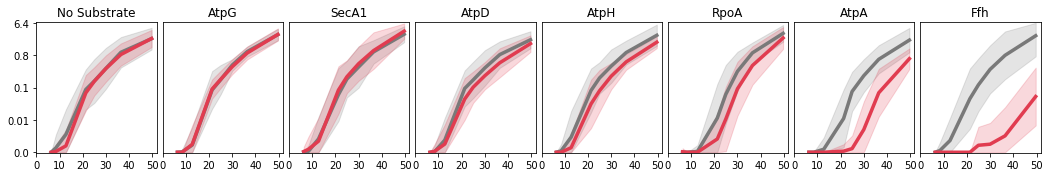

In [8]:
substrate_names = ['No Substrate','AtpG','SecA1','AtpD','AtpH','RpoA','AtpA','Ffh']
ctrl_color=np.array([121,121,121])/255
rapa_color=np.array([225,60,80])/255
pix_n = 2000
w=80
pix_mm = w/pix_n
pix_mm2 = pix_mm**2
fig=plt.figure(figsize=(18,2.4))
grids =gs(1,8,wspace=0.05)
for k,i in enumerate([2,14,10,16,12,4,6,8]):
    substrate = substrate_names[k]
    no_rapa = filtered[(filtered['plate']==i-1)&(filtered['group']=='group_2')].copy()
    no_rapa['Substrate'] = substrate_names[k]
    with_rapa = filtered[(filtered['plate']==i)&(filtered['group']=='group_2')].copy()
    with_rapa['Substrate'] = substrate_names[k]
    ax = fig.add_subplot(grids[:,k])
    stack = []
    for cid in no_rapa['colony_id'].unique():
        subset = no_rapa[no_rapa['colony_id']==cid]
        if subset['area'].values.max()>100:
            stack.append(np.log2(subset['area'].values+1))
            #plt.plot(subset['time'].values,subset['area'].values,color=ctrl_color,lw=1,alpha=0.1)
            times = subset['time'].values
    mean_v, std_v = np.mean(stack,axis=0),np.std(stack,axis=0)
    plt.plot(subset['time'].values[times<52],mean_v[times<52],color=ctrl_color,lw=3.5)
    low_bound = mean_v-std_v
    low_bound[low_bound<0]=0
    high_bound = mean_v+std_v
    high_bound[high_bound>np.log2(4001)]=np.log2(4001)
    plt.fill_between(subset['time'].values[times<52],low_bound[times<52],high_bound[times<52],color=ctrl_color,alpha=0.2)
    stack = []
    for cid in with_rapa['colony_id'].unique():
        subset = with_rapa[with_rapa['colony_id']==cid]
        if subset['area'].values.max()>100:
            stack.append(np.log2(subset['area'].values+1))
            #plt.plot(subset['time'].values,subset['area'].values,color=rapa_color,lw=1,alpha=0.1)
    mean_v, std_v = np.mean(stack,axis=0),np.std(stack,axis=0)
    plt.plot(subset['time'].values[times<52],mean_v[times<52],color=rapa_color,lw=3.5)
    low_bound = mean_v-std_v
    low_bound[low_bound<0]=0
    high_bound = mean_v+std_v
    high_bound[high_bound>np.log2(4001)]=np.log2(4001)
    plt.fill_between(subset['time'].values[times<52],low_bound[times<52],high_bound[times<52],color=rapa_color,alpha=0.2)
    plt.title(substrate)
    ax.set_yticks(np.linspace(0,np.log2(4000),5))
    ax.set_yticklabels(np.round(2**(np.linspace(0,np.log2(4000),5))*pix_mm2,2))
    ax.set_xticks([0,10,20,30,40,50])
    if k!=0:
        ax.set_yticks([])
    ax.set_ylim(-0.05,np.log2(4000)+0.05)
#plt.savefig('/Users/jz-rolling/Desktop/colony_growth_refined.svg'.format(substrate),bbox_inches='tight')
    